## 5.4 단순한 계층 구현하기

### 5.4.1 곱셈계층

In [1]:
class MulLayer:
    def __init__(self):
        self.x=None
        self.y=None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x*y
        return out
    
    def backward(self, dout):
        dx = dout*self.y # x와 y를 바꾼다
        dy = dout*self.x
        return dx,dy

In [2]:
apple = 100
apple_num = 2
tax = 1.1

In [3]:
# 계층들 생성
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# 순전파
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [9]:
# 역전파

dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [10]:
print(dapple)
print(dapple_num)
print(dtax)

2.2
110.00000000000001
200


### 5.4.2 덧셈계층

In [12]:
class AddLayer:
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x+y
        return out
    
    def backward(self, dout):
        dx = dout*1
        dy = dout*1
        return dx, dy

## 5.5 활성화 함수 계층 구현하기

### 5.5.1 ReLU 계층

In [14]:
class ReLU:
    def __init__(self):
        self.mask = None # mask는 True/Falas로 구성된 numpy 배열
        
    def forward(self, x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask]=0
        return out
    
    def backward(self, dout):
        dout[self.mask]=0
        dx=dout
        return dx  

In [15]:
x=np.array([[1.0,-0.5],[-2.0,3.0]])
x

array([[ 1. , -0.5],
       [-2. ,  3. ]])

In [16]:
mask = (x<=0)
mask

array([[False,  True],
       [ True, False]])

### 5.5.2 sigmoid 계층

In [17]:
class sigmoid:
    def __init__(self):
        self.out=None
        
    def forward(self, x):
        out=1/(1+np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout*(1.0-self.out) * self.out
        return dx

## 5.6 Affine/Softmax 계층 구현하기

### 5.6.1 Affine 계층

In [18]:
X=np.random.rand(2) # 입력
W=np.random.rand(2,3) # 가중치
B=np.random.rand(3) # 편향

In [20]:
Y = np.dot(X,W)+B
Y, Y.shape

(array([1.47431752, 1.61781155, 0.91816503]), (3,))

### 5.6.2 배치(데이터 묶음)용 Affine 계층

In [21]:
X_dot_W = np.array([[0,0,0],[10,10,10]])
B=np.array([1,2,3])

In [22]:
X_dot_W

array([[ 0,  0,  0],
       [10, 10, 10]])

In [25]:
B

array([1, 2, 3])

In [24]:
X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [26]:
dY = np.array([[1,2,3],[4,5,6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [29]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [31]:
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dou, axis=0)
        return dx

In [33]:
import sys, os
sys.path.append(os.pardir)
from common.functions import softmax # 분류문제 활성화 함수
from common.functions import cross_entropy_error # 손실함수

In [36]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self, x, t):
        self.t=t
        self.y=softmax(x)
        self.loss=cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y-self.t)/batch_size
        return dx

### 5.7.2 오차역전파법을 적용한 신경망 구현하기

In [37]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

In [38]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        # 계층생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y=self.predict(x)
        return self.lastLayer.forward(y,t)
    
    def accuracy(self, x, t):
        y=self.predict(x)
        y=np.argmax(y,axis=1)
        if t.ndim!=1 : 
            t=np.argmax(t, axis=1)
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W:self.loss(x,t)
        
        grads={}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x,t)
        
        # 역전파
        dout=1
        dout=self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과저장
        grads={}
        grads['W1']=self.layers['Affine1'].dW
        grads['b1']=self.layers['Affine1'].db
        grads['W2']=self.layers['Affine2'].dW        
        grads['b2']=self.layers['Affine2'].db        
        return grads
        

### 5.7.3 오차역전파법으로 구한 기울기 수치 미분방법으로 검증하기

In [46]:
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

In [47]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [48]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [49]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [50]:
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

In [51]:
# 각 가중치의 차이의 절대값을 구한 후, 그 절댓값들의 평균을 낸다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key+":"+str(diff))

W1:4.962235820987004e-10
b1:2.7575675051370005e-09
W2:6.39333678422455e-09
b2:1.4064429902233e-07


### 5.7.4 오차역전파법을 사용한 학습 구현하기

In [52]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [53]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [54]:
iters_num = 10000  
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [55]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [57]:
iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    # 오차역전파법으로 기울기 구함
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.18103333333333332, 0.185
train acc, test acc | 0.9055166666666666, 0.9083
train acc, test acc | 0.9252333333333334, 0.9263
train acc, test acc | 0.9359666666666666, 0.9358
train acc, test acc | 0.9416666666666667, 0.9433
train acc, test acc | 0.9512166666666667, 0.9489
train acc, test acc | 0.9569, 0.9545
train acc, test acc | 0.9605666666666667, 0.9584
train acc, test acc | 0.96445, 0.9598
train acc, test acc | 0.96605, 0.9618
train acc, test acc | 0.9681666666666666, 0.9626
train acc, test acc | 0.9713333333333334, 0.9661
train acc, test acc | 0.9732333333333333, 0.9673
train acc, test acc | 0.97495, 0.9695
train acc, test acc | 0.9751666666666666, 0.9688
train acc, test acc | 0.97685, 0.9701
train acc, test acc | 0.9783333333333334, 0.9701


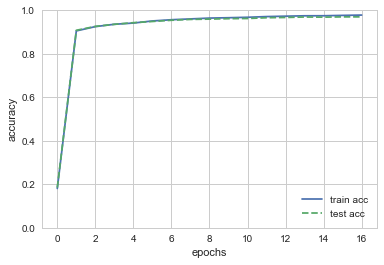

In [58]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()